In [1]:
using QuadraticTeamDecisionSolver, Distributions, Statistics, LinearAlgebra, Plots, LaTeXStrings

In [2]:
#replace with desired directory
saveTo = "/home/fe/michelena/Schreibtisch/";
dpi=1000;

### problem specification


In [3]:
N = K = 2;
L = 1
P = 0.8;
σₕ = 1.0;
σₙ = σₕ/10;
ϵ = 0.8;
p = QuadTeamProblem(N, N * K * L * ones(Int64, N), L*ones(Int64, N), ComplexF64);
t = teamMMSEproblem(
	P,
	N,
	L,
	K,
	σₕ * ones(Float64, N),
	σₙ * ones(Float64, N),
	ϵ * ones(Float64, N)
);


In [4]:
p = checkProblem(p)

QuadTeamProblem{ComplexF64}(2, [4, 4], [1, 1], ComplexF64)

### Data Sets

In [5]:
m_train = 500;
m_test = 2000;
iters = 20;
Y_train, Q_train, R_train = generateTeamMMSEsamples(t, m_train);
Y_test, Q_test, R_test = generateTeamMMSEsamples(t, m_test);

In [6]:
h11 = histogram2d([y[1] for y in Y_test[1]], colorbar=false, title=L"\mathbf{Y}_1[1,1]");
h12 = histogram2d([y[2] for y in Y_test[1]], colorbar=false, title=L"\mathbf{Y}_1[2,1]");
h13 = histogram2d([y[3] for y in Y_test[1]], colorbar=false, title=L"\mathbf{Y}_1[1,2]");
h14 = histogram2d([y[4] for y in Y_test[1]], colorbar=false, title=L"\mathbf{Y}_1[2,2]");
h21 = histogram2d([y[1] for y in Y_test[2]], colorbar=false, title=L"\mathbf{Y}_2[1,1]");
h22 = histogram2d([y[2] for y in Y_test[2]], colorbar=false, title=L"\mathbf{Y}_2[2,1]");
h23 = histogram2d([y[3] for y in Y_test[2]], colorbar=false, title=L"\mathbf{Y}_2[1,2]");
h24 = histogram2d([y[4] for y in Y_test[2]], colorbar=false, title=L"\mathbf{Y}_2[2,2]");
plot(h11, h13, h21, h23, h12, h14, h22, h24, layout=(2,4), size=(1200,700), dpi=dpi)
savefig(saveTo * "/Y-histograms-2-agents.png")
display(Plots.current())

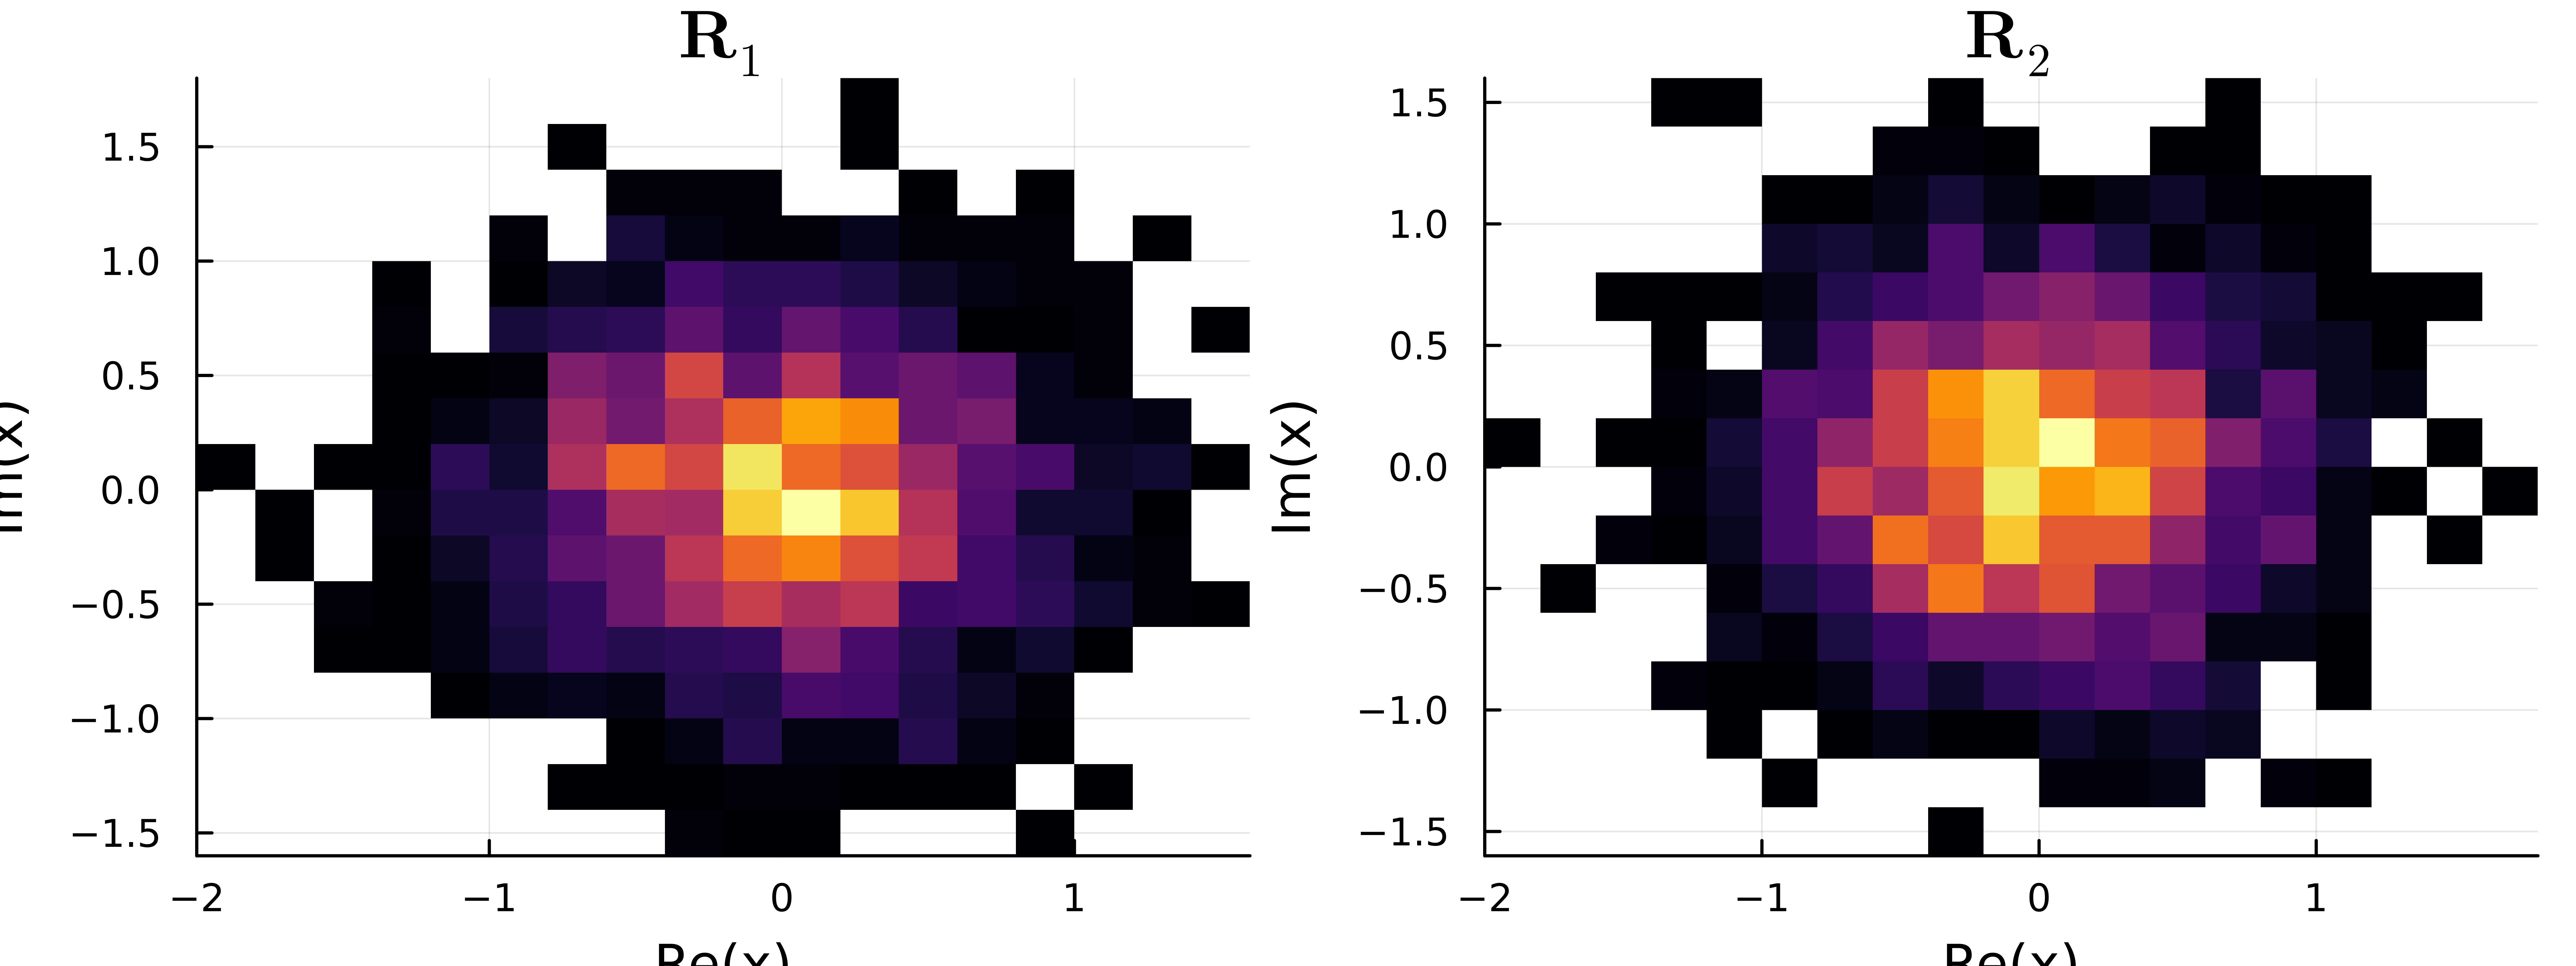

In [7]:
h1 = histogram2d(vcat(R_test[1]...), colorbar=false, title=L"\mathbf{R}_1");
h2 = histogram2d(vcat(R_test[2]...), colorbar=false, title=L"\mathbf{R}_2");
plot(h1, h2, size=(800, 300), dpi=dpi)
savefig(saveTo * "/R-histograms-2-agents.png")
display(Plots.current())

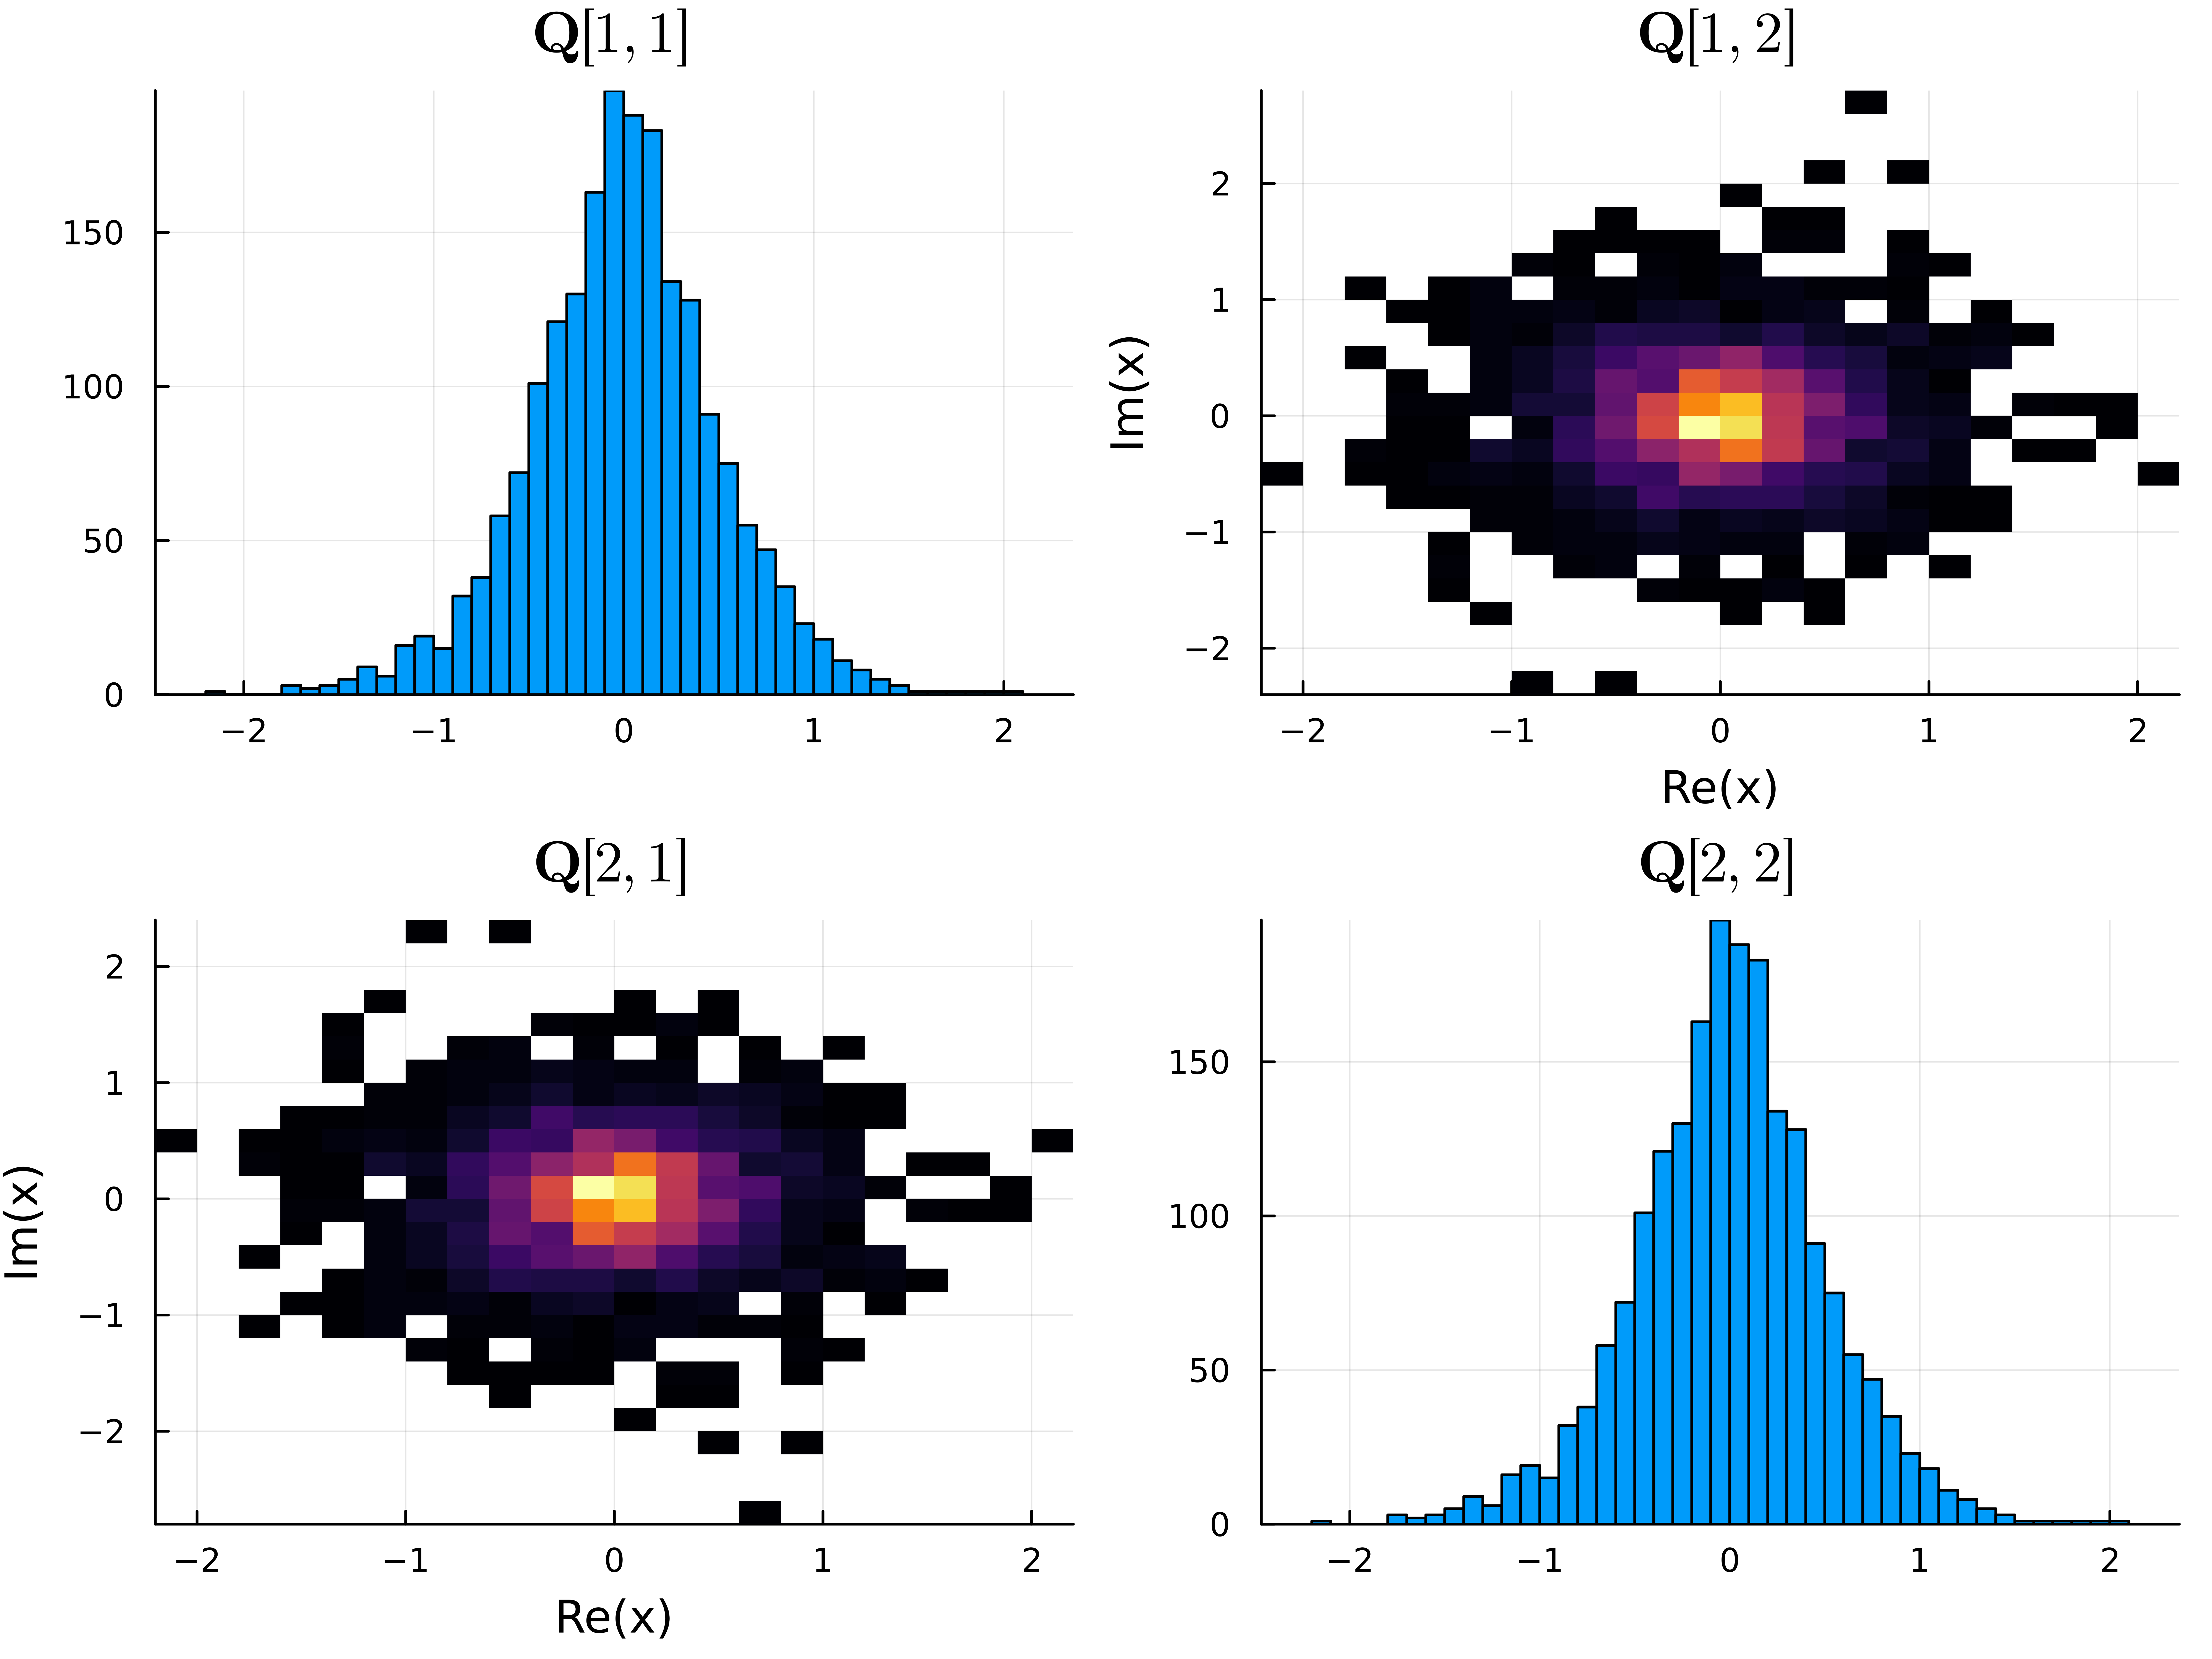

In [8]:
h11 = histogram(real(vcat(Q_test[2,1]...)), colorbar=false, title=L"\mathbf{Q}[1,1]", label=:none);
h12 = histogram2d(vec(vcat(Q_test[1,2]...)), colorbar=false, title=L"\mathbf{Q}[1,2]");
h21 = histogram2d(vec(vcat(Q_test[2,1]...)), colorbar=false, title=L"\mathbf{Q}[2,1]");
h22 = histogram(real(vcat(Q_test[1,2]...)), colorbar=false, title=L"\mathbf{Q}[2,2]", label=:none);
plot(h11, h12, h21, h22, size=(800, 600), dpi=dpi)
savefig(saveTo * "/Q-histograms-2-agents.png")
display(Plots.current())

In [9]:
Q_eigvals = hcat.(vcat.(Q_test[1,1], Q_test[2,1]), vcat.(Q_test[1,2], Q_test[2,2]));
min_Q_eigvals = Q_eigvals .|> x -> minimum(real.(eigvals(x)));
max_Q_eigvals = Q_eigvals .|> x -> maximum(real.(eigvals(x)));

In [38]:
Q_eigvals_total = hcat(real.(eigvals.(Q_eigvals))...);

2×2000 Matrix{Float64}:
 1.39804  1.39237  1.31746  1.29045  …  1.31504  1.25393  1.37606  1.47299
 3.19308  4.16262  1.53398  4.97879     2.02407  1.94482  3.99444  2.99683

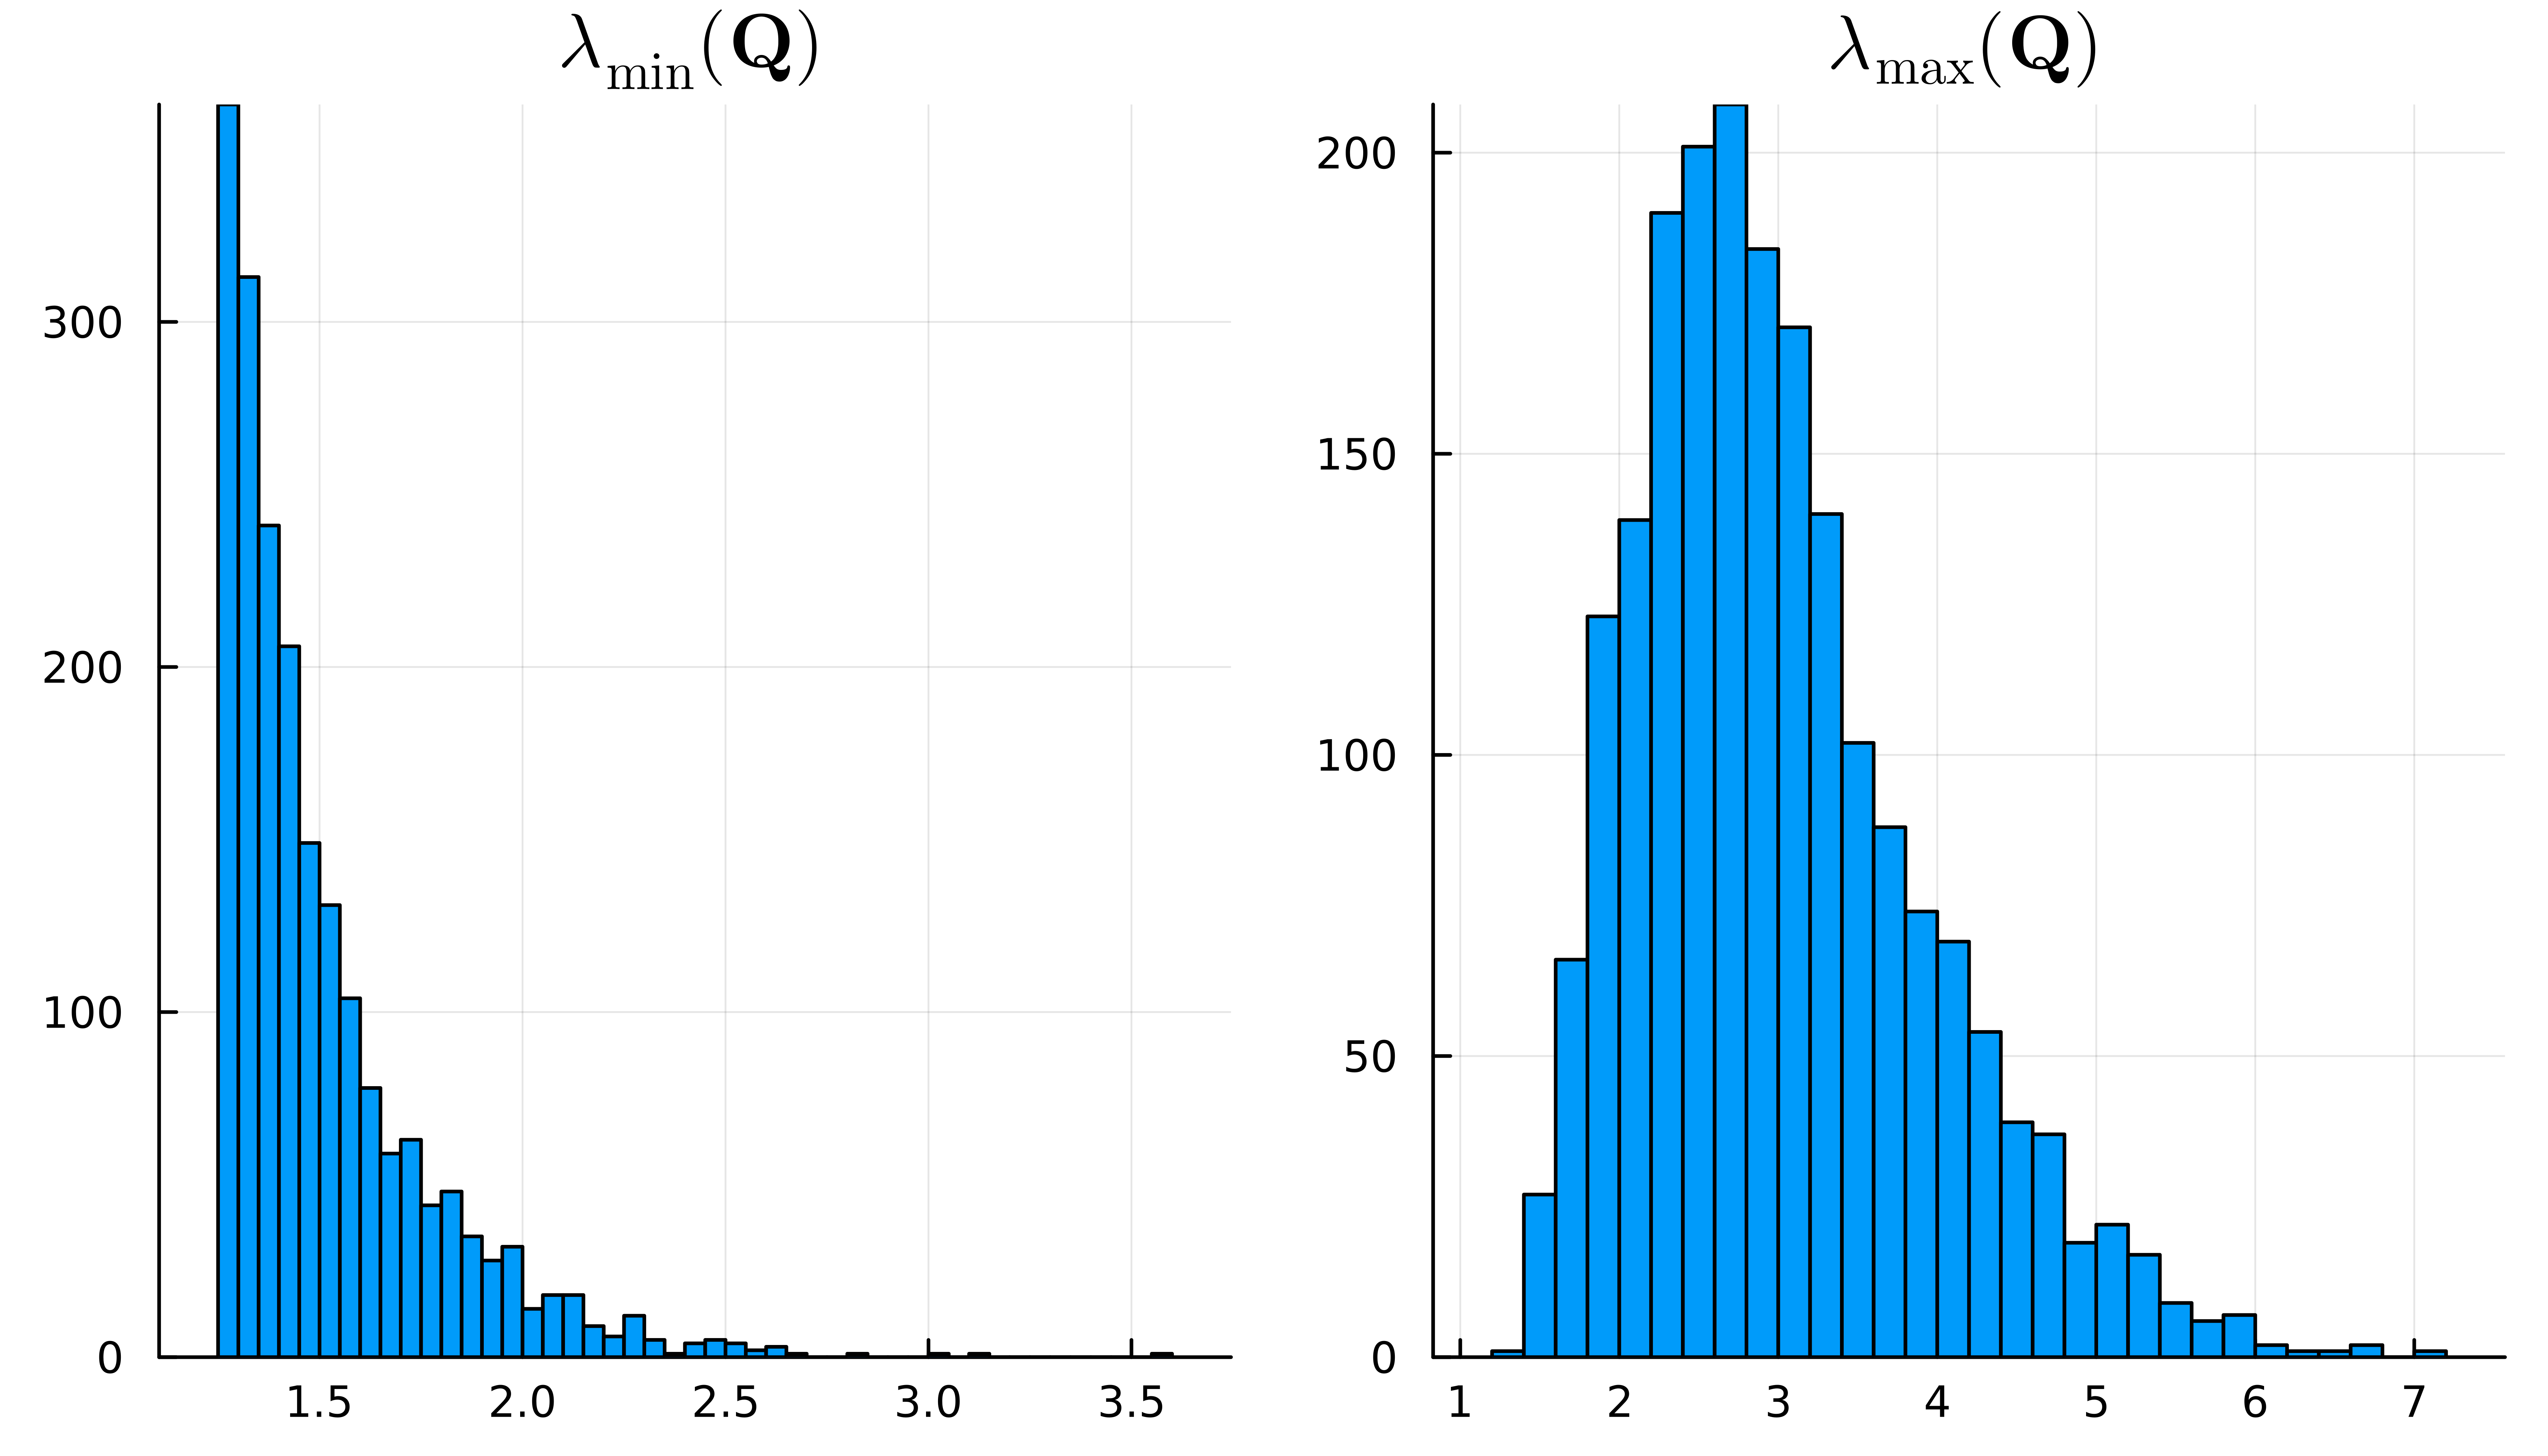

In [24]:
h1 = histogram(min_Q_eigvals, title=L"\lambda_{\mathrm{min}}(\mathbf{Q})", label=:none);
h2 = histogram(max_Q_eigvals, title=L"\lambda_{\mathrm{max}}(\mathbf{Q})", label=:none);
plot(h1, h2, size=(700,400), dpi=dpi)
savefig(saveTo * "/Q-eigvals-histograms-2-agents.png")
display(Plots.current())

### Kernel and Solver Specifications

In [12]:
h₁ = 1.0;
h₂ = 1.0;
λ₁ = σₙ^2; #noise variance
λ₂ = σₙ^2;

k₁(x,y) = exponentialKernel(x,y,h=h₁);
k₂(x,y) = exponentialKernel(x,y,h=h₂);

kernels = [k₁, k₂];
λ = [λ₁, λ₂];

In [13]:
γj = jacobiSolver(p, m_train, Y_train, Q_train, R_train, kernels, λ, iterations=iters);

In [14]:
γg = gaussSeidelSolver(p, m_train, Y_train, Q_train, R_train, kernels, λ, iterations=iters);

In [15]:
resJacobi = [residual(m_train, p, kernels, [γj[1][k], γj[2][k]], Y_train, Q_train, R_train, λ) for k in 1:iters];
resGaussSeidel = [residual(m_train, p, kernels, [γg[1][k], γg[2][k]], Y_train, Q_train, R_train, λ) for k in 1:iters];

In [16]:
resJ  = [[x -> kernelFunction(kernels[i], resJacobi[l][i], Y_train[i], x) for i in 1:p.N] for l in 1:iters];
resG  = [[x -> kernelFunction(kernels[i], resGaussSeidel[l][i], Y_train[i], x) for i in 1:p.N] for l in 1:iters];

In [17]:
perfJ = [GammaNorm(resJ[l], Y_test, p=2) for l in 1:iters];
perfG = [GammaNorm(resG[l], Y_test, p=2) for l in 1:iters];

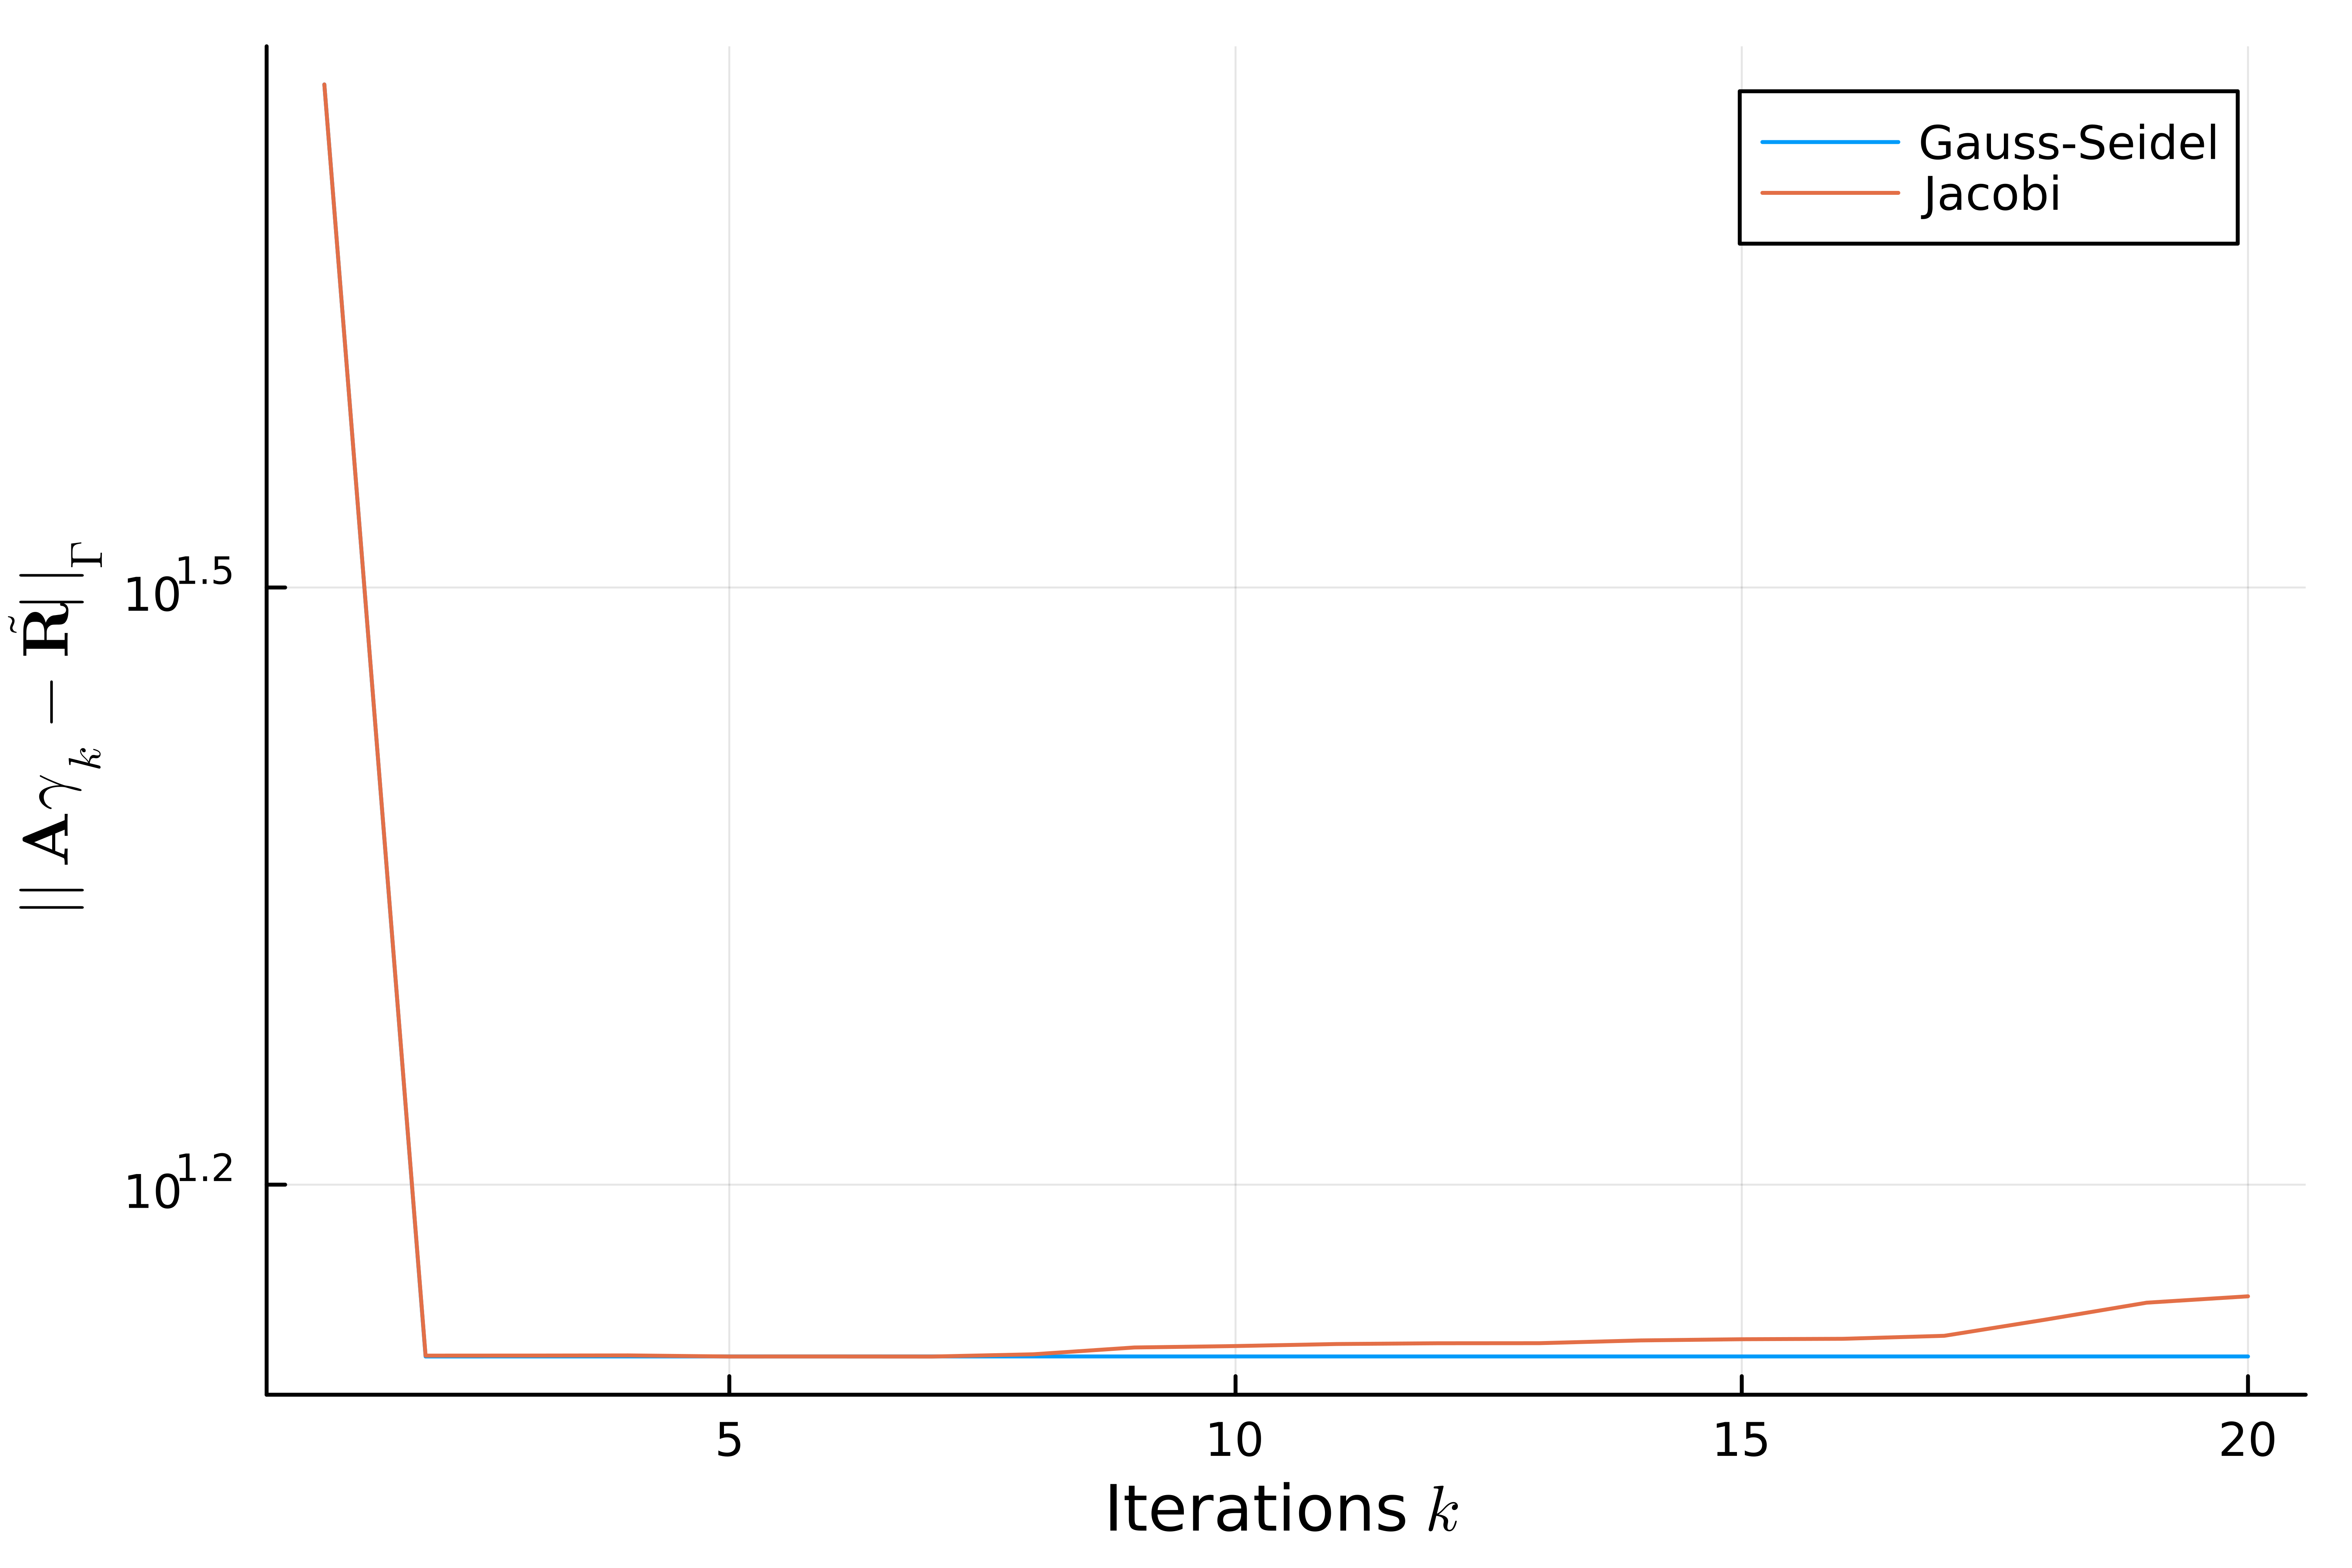

In [18]:
plot(1:iters, [perfG, perfJ], label=["Gauss-Seidel" "Jacobi"], yscale=:log10, dpi=dpi)
xlabel!("Iterations "*L"k")
ylabel!(L"||\mathbf{A}\gamma_k - \mathbf{\tilde{R}}||_{\Gamma}")
savefig(saveTo * "/residual-performance-2-agents.png")
display(Plots.current())

In [19]:
convJ = [diff(γj[i]) for i in 1:p.N];
convG = [diff(γg[i]) for i in 1:p.N];
strongConvJ = [
	GammaNorm(
		[
			x -> kernelFunction(k₁, convJ[1][k], Y_train[1], x),
			x -> kernelFunction(k₂, convJ[2][k], Y_train[2], x),
		],
		Y_test,
		p = 2,
	) for k in 1:iters
];
strongConvG = [
	GammaNorm(
		[
			x -> kernelFunction(k₁, convG[1][k], Y_train[1], x),
			x -> kernelFunction(k₂, convG[2][k], Y_train[2], x),
		],
		Y_test,
		p = 2,
	) for k in 1:iters
];
kernelNormConvJ = [
	sum([kernelNorm(convJ[i][k], gramian(kernels[i], Y_train[i])) for i in 1:p.N]) for
	k in 1:iters
];
kernelNormConvG = [
	sum([kernelNorm(convG[i][k], gramian(kernels[i], Y_train[i])) for i in 1:p.N]) for
	k in 1:iters
];


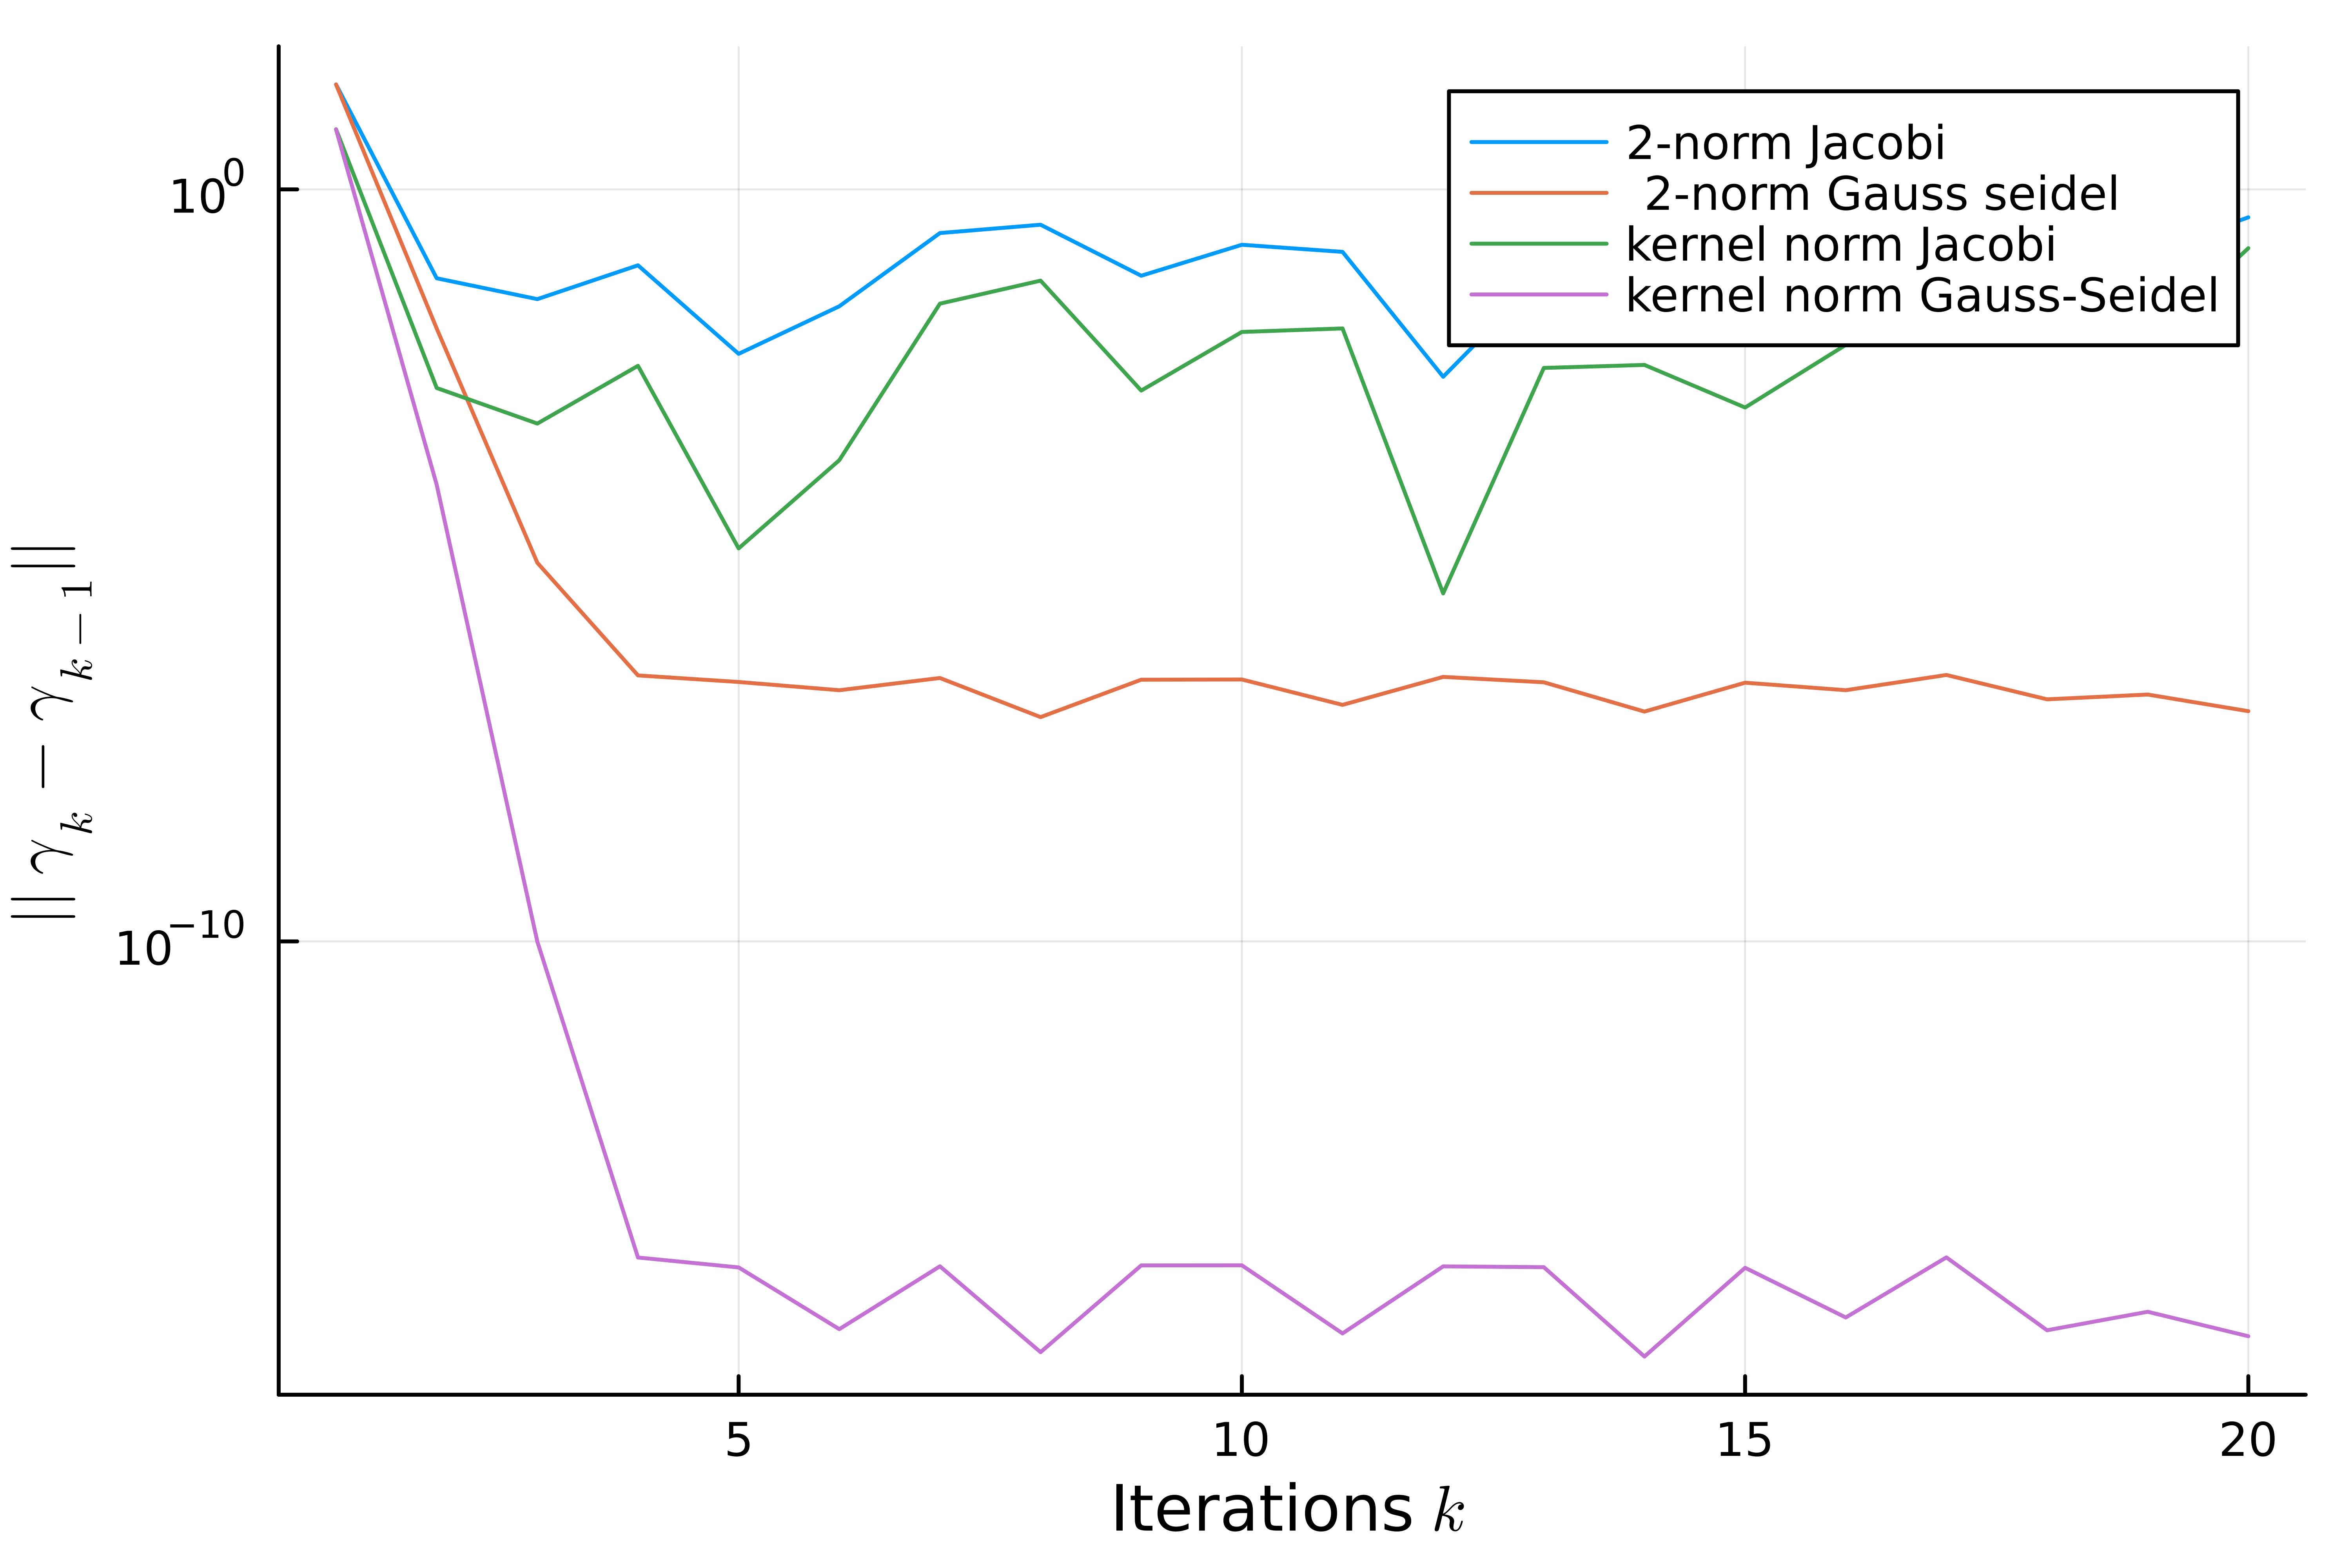

In [20]:
plot(
	1:iters,
	[strongConvJ, strongConvG, kernelNormConvJ, kernelNormConvG],
	label = ["2-norm Jacobi" " 2-norm Gauss seidel" "kernel norm Jacobi" "kernel norm Gauss-Seidel"],
	yscale = :log10,
	dpi=dpi
)
xlabel!("Iterations " * L"k")
ylabel!(L"||\gamma_k - \gamma_{k-1}||")
savefig(saveTo * "/strong-convergence-performance-2-agents.png")
display(Plots.current())


In [21]:
costPerfJ = [cost(p,
	[
		x -> kernelFunction(k₁, γj[1][k], Y_train[1], x),
		x -> kernelFunction(k₂, γj[2][k], Y_train[2], x),
	], Y_test, Q_test, R_test, ones(Float64, m_test))
for k in 1:iters];
costPerfG = [cost(p,
	[
		x -> kernelFunction(k₁, γg[1][k], Y_train[1], x),
		x -> kernelFunction(k₂, γg[2][k], Y_train[2], x),
	], Y_test, Q_test, R_test, ones(Float64, m_test))
for k in 1:iters];

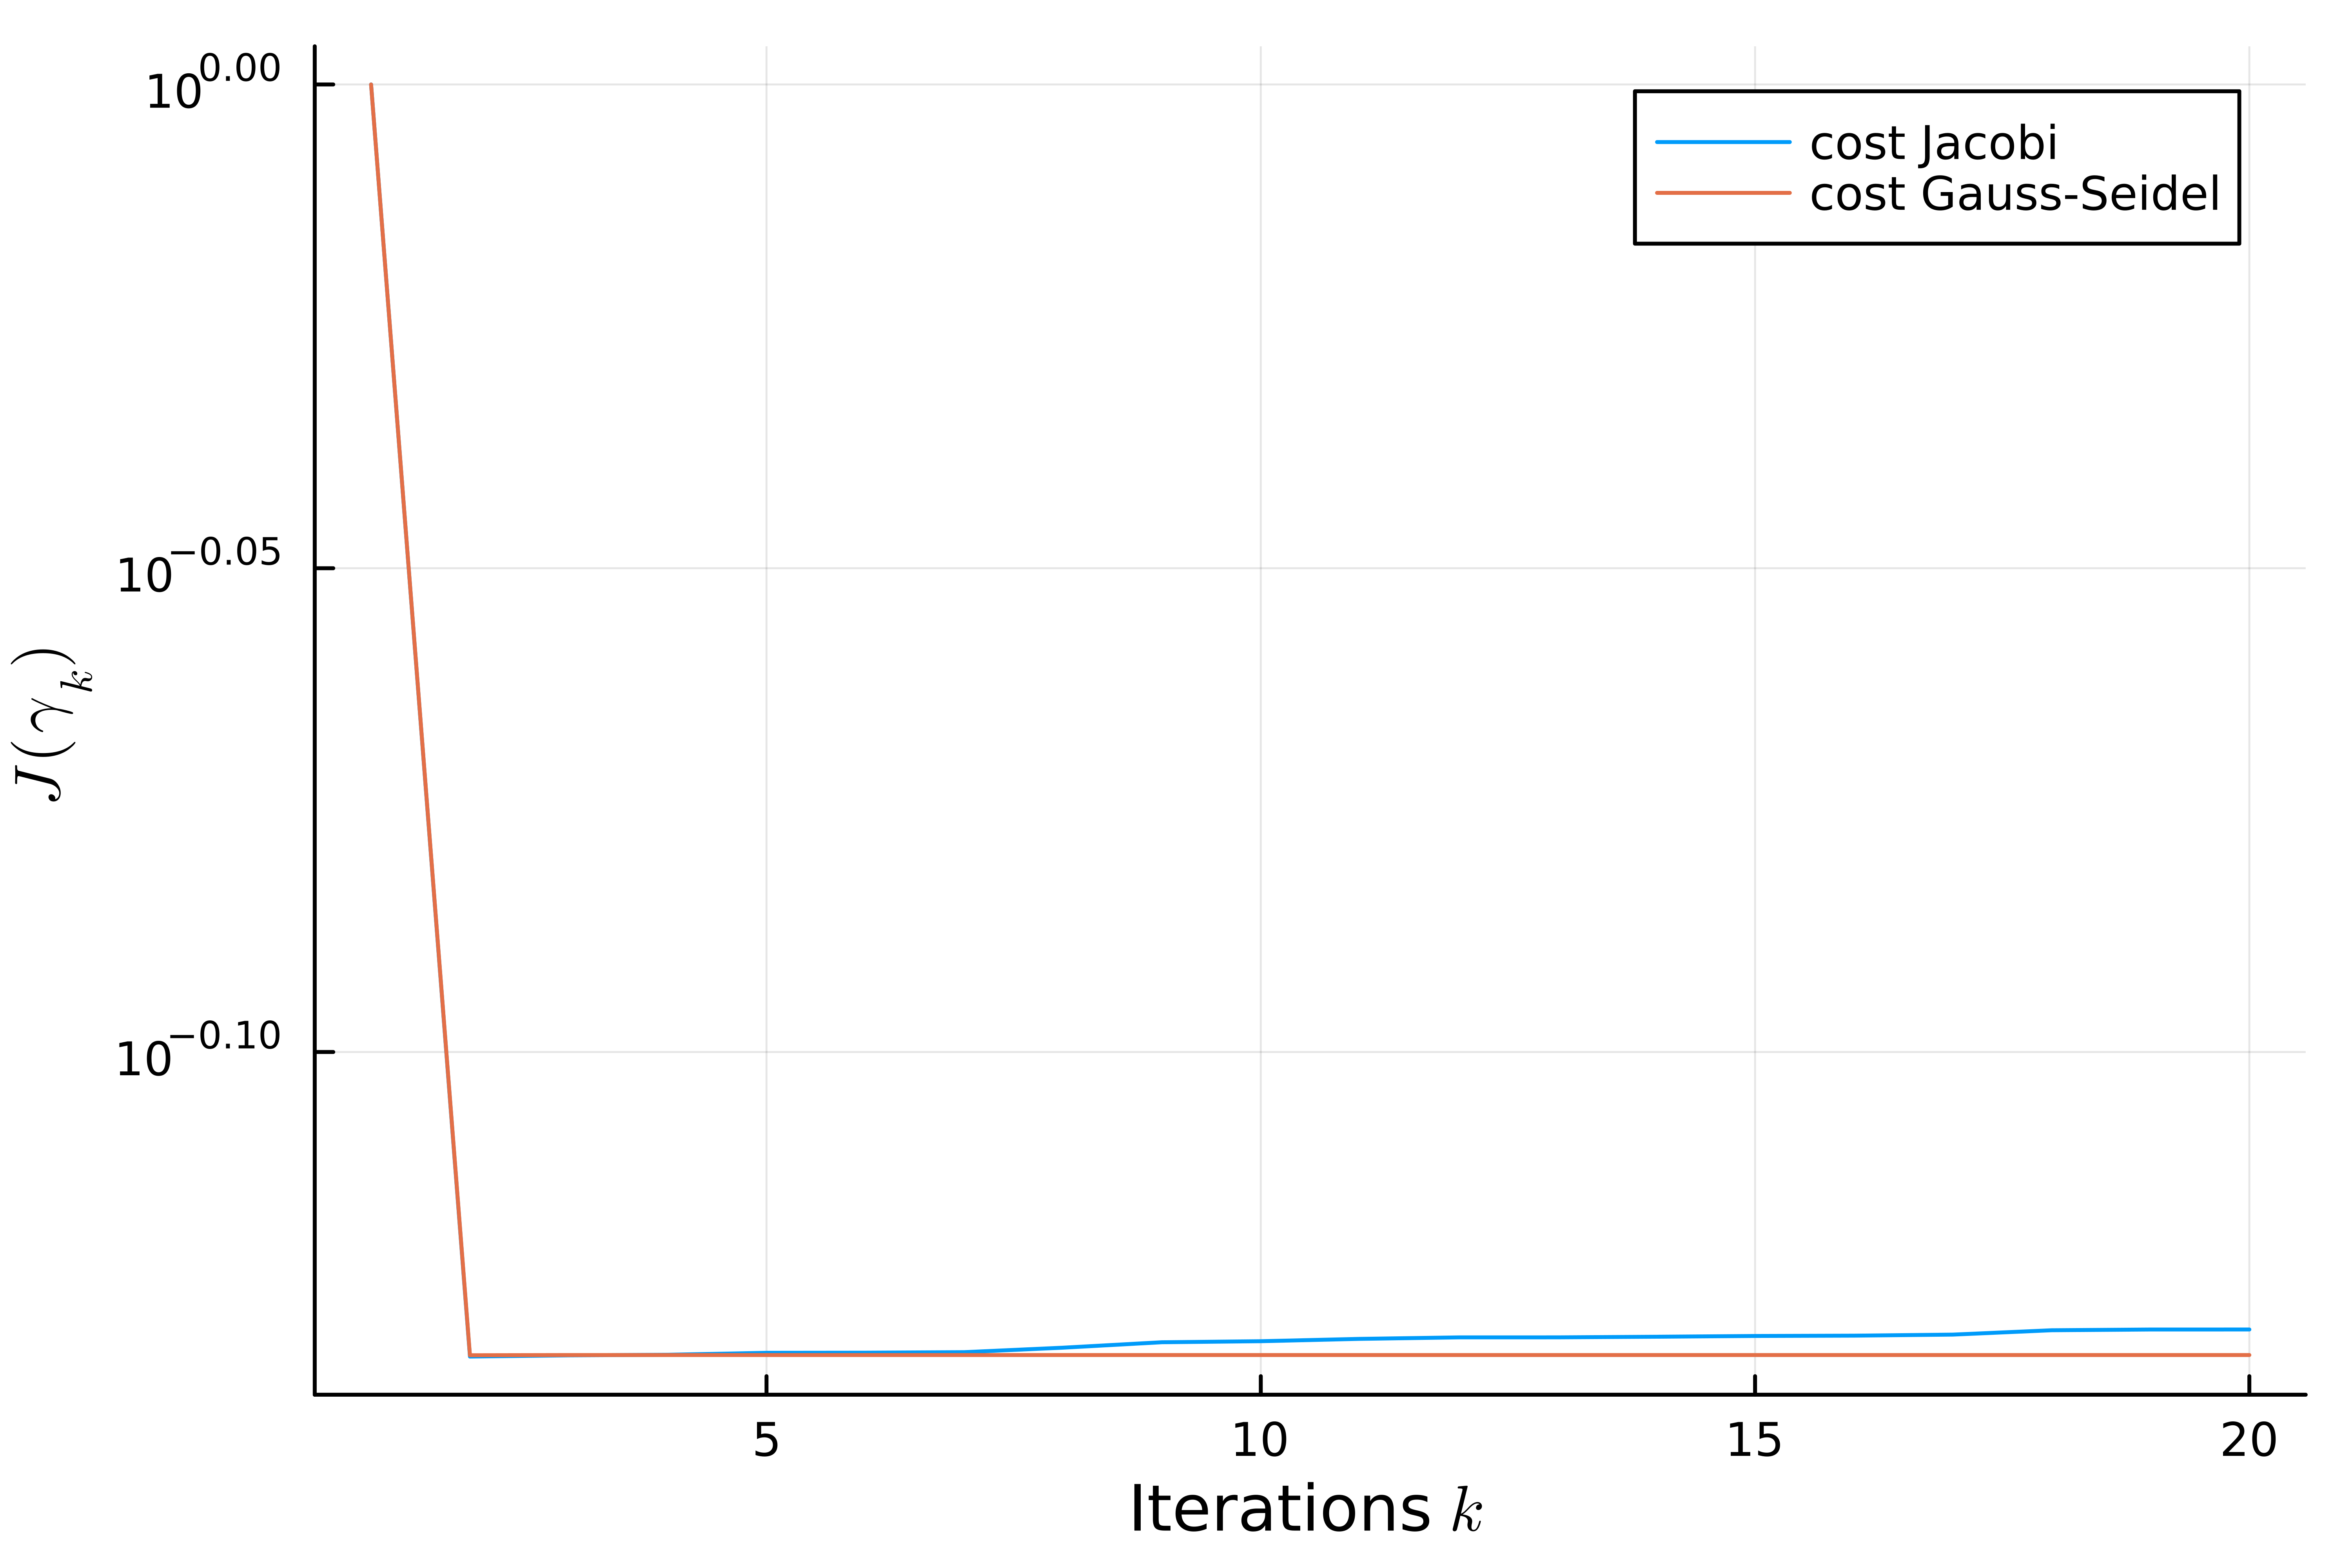

In [22]:
plot(1:iters, [costPerfJ, costPerfG], label=["cost Jacobi" "cost Gauss-Seidel"], yscale=:log10,dpi=dpi)
xlabel!("Iterations " * L"k")
ylabel!(L"J(\gamma_k)")
savefig(saveTo * "/cost-performance-2-agents.png")
display(Plots.current())